In [1]:
import torch

import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS, Predictive

import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float64)
KMP_DUPLICATE_LIB_OK=True

## Estimating the Speed of Light Model

This model is is derived from observations recorded in Bayesian Data Analysis. They (inappropriately) apply a Normal model. Note, we use un-informative priors of Uniform here.

In [22]:
numbs = "28 26 33 24 34 -44 27 16 40 -2 29 22 \
24 21 25 30 23 29 31 19 24 20 36 32 36 28 25 21 28 29 \
37 25 28 26 30 32 36 26 30 22 36 23 27 27 28 27 31 27 26 \
33 26 32 32 24 39 28 24 25 32 25 29 27 28 29 16 23"

In [23]:
nums = torch.tensor([int(i) for i in numbs.split(' ')], dtype=torch.double)

In [24]:
nums

tensor([ 28.,  26.,  33.,  24.,  34., -44.,  27.,  16.,  40.,  -2.,  29.,  22.,
         24.,  21.,  25.,  30.,  23.,  29.,  31.,  19.,  24.,  20.,  36.,  32.,
         36.,  28.,  25.,  21.,  28.,  29.,  37.,  25.,  28.,  26.,  30.,  32.,
         36.,  26.,  30.,  22.,  36.,  23.,  27.,  27.,  28.,  27.,  31.,  27.,
         26.,  33.,  26.,  32.,  32.,  24.,  39.,  28.,  24.,  25.,  32.,  25.,
         29.,  27.,  28.,  29.,  16.,  23.])

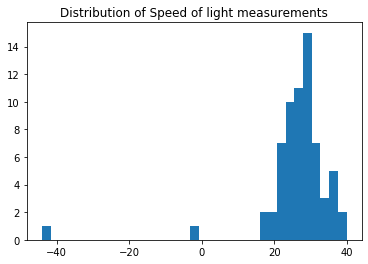

In [25]:
_, _, _, = plt.hist(nums, bins=35)
plt.title("Distribution of Speed of light measurements");

In [26]:
torch.mean(nums)

tensor(26.2121)

In [27]:
def light_model(nums):
    mu = pyro.sample("mu", dist.Uniform(10., 30.))
    sigma = pyro.sample("sigma", dist.Uniform(0., 20.))

    with pyro.plate("data", len(nums)):
        return pyro.sample("post", dist.Normal(mu, sigma), obs=nums)

In [28]:
nuts_kernel = NUTS(light_model)
mcmc = MCMC(nuts_kernel,
           num_samples=20000,
           warmup_steps=10000)

In [9]:
mcmc.run(nums)

Sample: 100%|██████████| 30000/30000 [04:07, 121.18it/s, step size=6.68e-01, acc. prob=0.911]


In [ ]:
mcmc.summary()

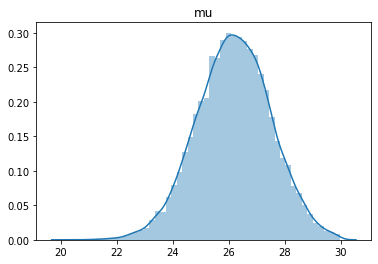

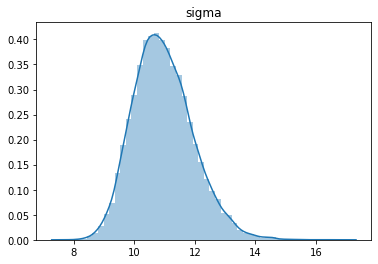

In [11]:
for name, support in mcmc.get_samples().items():
    sns.distplot(support)
    plt.title(name)
    plt.show()

## Example: Pre-election polling

This is an example of a multinomial model. In which we apply a model on survey data asking for their voting preferences.

In [2]:
obs = torch.tensor([727., 583., 137.])
bush = obs[0] / obs.sum()
duka = obs[1] / obs.sum()
other = obs[2] / obs.sum()

arr = torch.tensor([bush, duka, other])

In [3]:
arr

tensor([0.5024, 0.4029, 0.0947])

In [4]:
def election_model(votes):
    probs = pyro.sample("probs", dist.Uniform(0., 1.).expand([3]))
    with pyro.plate("data", len(votes)):
        pyro.sample("post", dist.Multinomial(probs=probs), obs=votes)


In [5]:
nuts_kernel = NUTS(election_model, jit_compile=True)

mcmc = MCMC(nuts_kernel,
           num_samples=20000,
           warmup_steps=2000)

In [6]:
mcmc.run(obs)

Warmup:   0%|          | 0/22000 [00:00, ?it/s]/Users/james.malcolm/anaconda3/envs/taxis/lib/python3.6/site-packages/ipykernel_launcher.py:7: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  import sys
/Users/james.malcolm/anaconda3/envs/taxis/lib/python3.6/site-packages/pyro/poutine/subsample_messenger.py:59: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  result = torch.tensor(0., device=self.device)
Sample: 100%|██████████| 22000/22000 [06:39, 55.12it/s, step size=9.85e-02, acc. prob=0.772] 


In [15]:
samples = mcmc.get_samples()

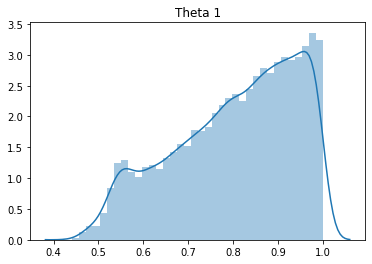

In [29]:
sns.distplot(samples['probs'].numpy()[:,0])
plt.title("Theta 1");

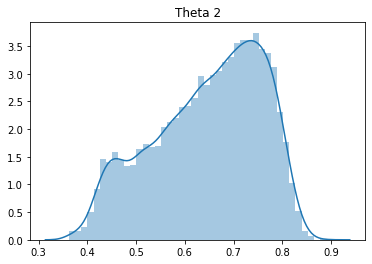

In [28]:
sns.distplot(samples['probs'].numpy()[:,1])
plt.title("Theta 2");

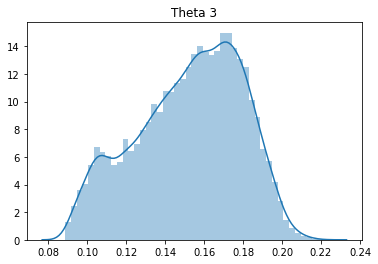

In [27]:
sns.distplot(samples['probs'].numpy()[:,2])
plt.title("Theta 3");

In [30]:
def election_model_two(votes):
    theta = pyro.sample("theta", dist.Dirichlet(torch.ones_like(votes)))
    
    with pyro.plate("data", len(votes)):
        pyro.sample("post", dist.Multinomial(probs=theta), obs=votes)

In [32]:
nuts_kernel_two = NUTS(election_model_two, jit_compile=True)

mcmc_two = MCMC(nuts_kernel_two,
           num_samples=20000,
           warmup_steps=2000)

In [33]:
mcmc_two.run(obs)

Warmup:   0%|          | 0/22000 [00:00, ?it/s]/Users/james.malcolm/anaconda3/envs/taxis/lib/python3.6/site-packages/ipykernel_launcher.py:4: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  after removing the cwd from sys.path.
/Users/james.malcolm/anaconda3/envs/taxis/lib/python3.6/site-packages/pyro/poutine/subsample_messenger.py:59: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  result = torch.tensor(0., device=self.device)
Sample: 100%|██████████| 22000/22000 [02:14, 163.80it/s, step size=8.12e-01, acc. prob=0.927]


In [34]:
mcmc_two.get_samples()

{'theta': tensor([[0.4934, 0.4089, 0.0977],
         [0.4920, 0.4162, 0.0918],
         [0.4908, 0.4159, 0.0933],
         ...,
         [0.5003, 0.3999, 0.0998],
         [0.4989, 0.4046, 0.0965],
         [0.4989, 0.4046, 0.0965]])}

In [35]:
samples_two = mcmc_two.get_samples()

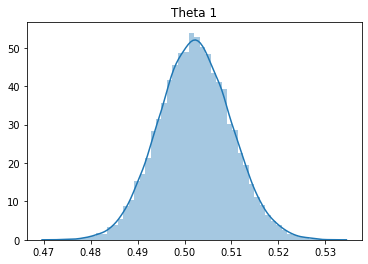

In [40]:
sns.distplot(samples_two['theta'].numpy()[:,0])
plt.title("Theta 1");

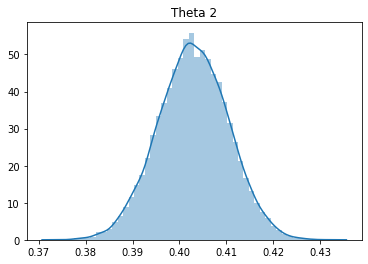

In [41]:
sns.distplot(samples_two['theta'].numpy()[:,1])
plt.title("Theta 2");

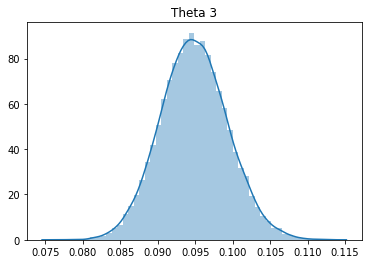

In [42]:
sns.distplot(samples_two['theta'].numpy()[:,2])
plt.title("Theta 3");

## Example: analysis of a bioassay experiment

In [43]:
x_dose = torch.tensor([-0.86, -0.3, -0.05, 0.73])
n_anim = torch.tensor([5., 5., 5., 5.])
y_deat = torch.tensor([0., 1., 3., 5.])

In [53]:
def bio(x_dose, y_deat):
    alpha = pyro.sample("alpha", dist.Uniform(-5., 7.))
    beta = pyro.sample("beta", dist.Uniform(0., 50.))
    
    theta = torch.sigmoid(alpha + beta * x_dose)
    
    with pyro.plate("data", len(y_deat)):
        pyro.sample("post", dist.Binomial(probs=theta), obs=y_deat)

In [56]:
bio_kernel = NUTS(bio)

mcmc_bio = MCMC(bio_kernel,
           num_samples=20000,
           warmup_steps=2000)

In [ ]:
mcmc_bio.run(x_dose, y_deat)

Warmup:   0%|          | 0/22000 [00:00, ?it/s]